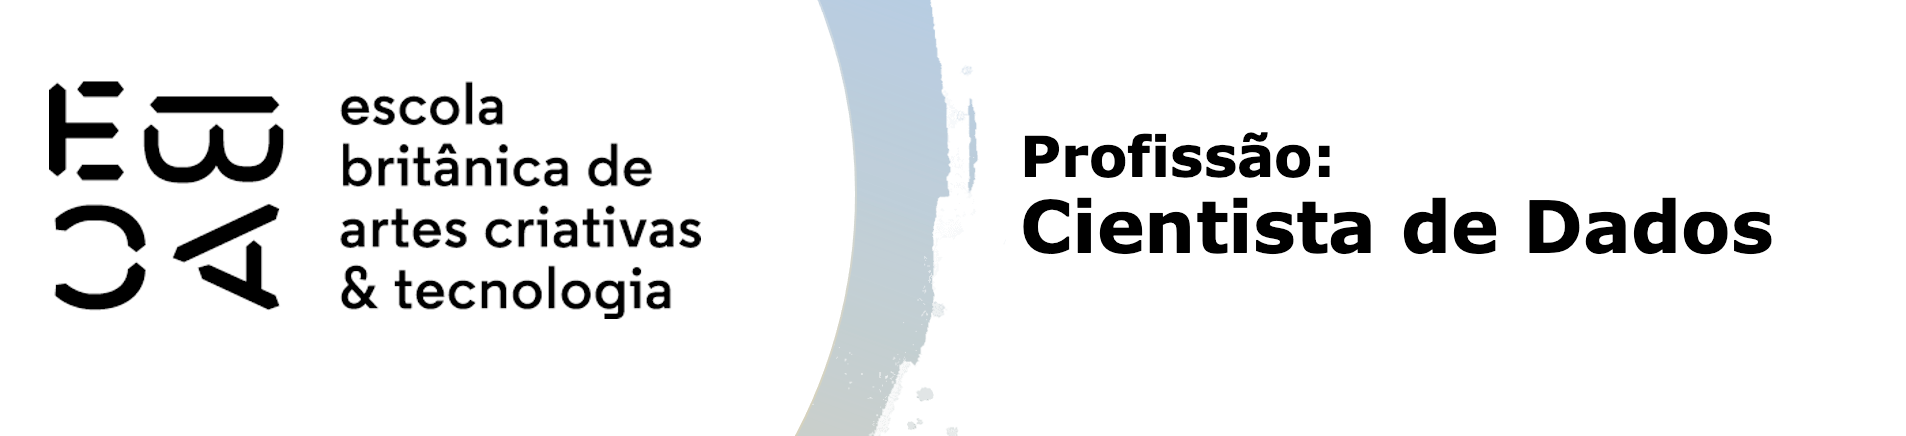

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 


In [12]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [13]:
# Obter os últimos 3 valores únicos de 'data_ref'
ultimos_3 = sorted(df['data_ref'].unique())[-3:]

# Separar os dados em treino e validação OOT
df_treino = df[~df['data_ref'].isin(ultimos_3)].drop(columns=['data_ref', 'index']).copy()
df_oot = df[df['data_ref'].isin(ultimos_3)].drop(columns=['data_ref', 'index']).copy()

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {df_treino.shape}")
print(f"Tamanho do conjunto de OOT: {df_oot.shape}")

Tamanho do conjunto de treino: (600000, 13)
Tamanho do conjunto de OOT: (150000, 13)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [14]:
# Número total de linhas
linhas_total = df.shape[0]

# Número de linhas por mês em data_ref
linhas_por_mes = df['data_ref'].value_counts().sort_index()

print(f"Número total de linhas: {linhas_total}")
print("Número de linhas por mês em data_ref:")
print(linhas_por_mes)

Número total de linhas: 750000
Número de linhas por mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [15]:
# Identificação das variáveis qualitativas e quantitativas
qualitativas = df.select_dtypes(include=['object', 'category']).columns
quantitativas = df.select_dtypes(include=['number']).columns

# Descritiva para variáveis qualitativas
print("### Descritiva das variáveis qualitativas ###")
for col in qualitativas:
    print(f"\n{col}:\n{df[col].value_counts().to_string()}")

# Descritiva para variáveis quantitativas
print("\n### Descritiva das variáveis quantitativas ###")
df[quantitativas].describe().T

### Descritiva das variáveis qualitativas ###

sexo:
sexo
F    504580
M    245420

posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046

posse_de_imovel:
posse_de_imovel
S    503692
N    246308

tipo_renda:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361

educacao:
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812

estado_civil:
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613

tipo_residencia:
tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290

### Descritiva das variáveis quantitativas ###


,count,mean,std,min,25%,50%,75%,max
index,750000.0,8319.272793,4809.281774,0.000000,4147.000000,8324.000000,12487.000000,1.664900e+04
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,624043.0,7.748574,6.687455,0.117808,3.049315,6.046575,10.183562,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [16]:
# Separando as variáveis qualitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
                'educacao', 'estado_civil', 'tipo_residencia']

# Separando as variáveis quantitativas
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

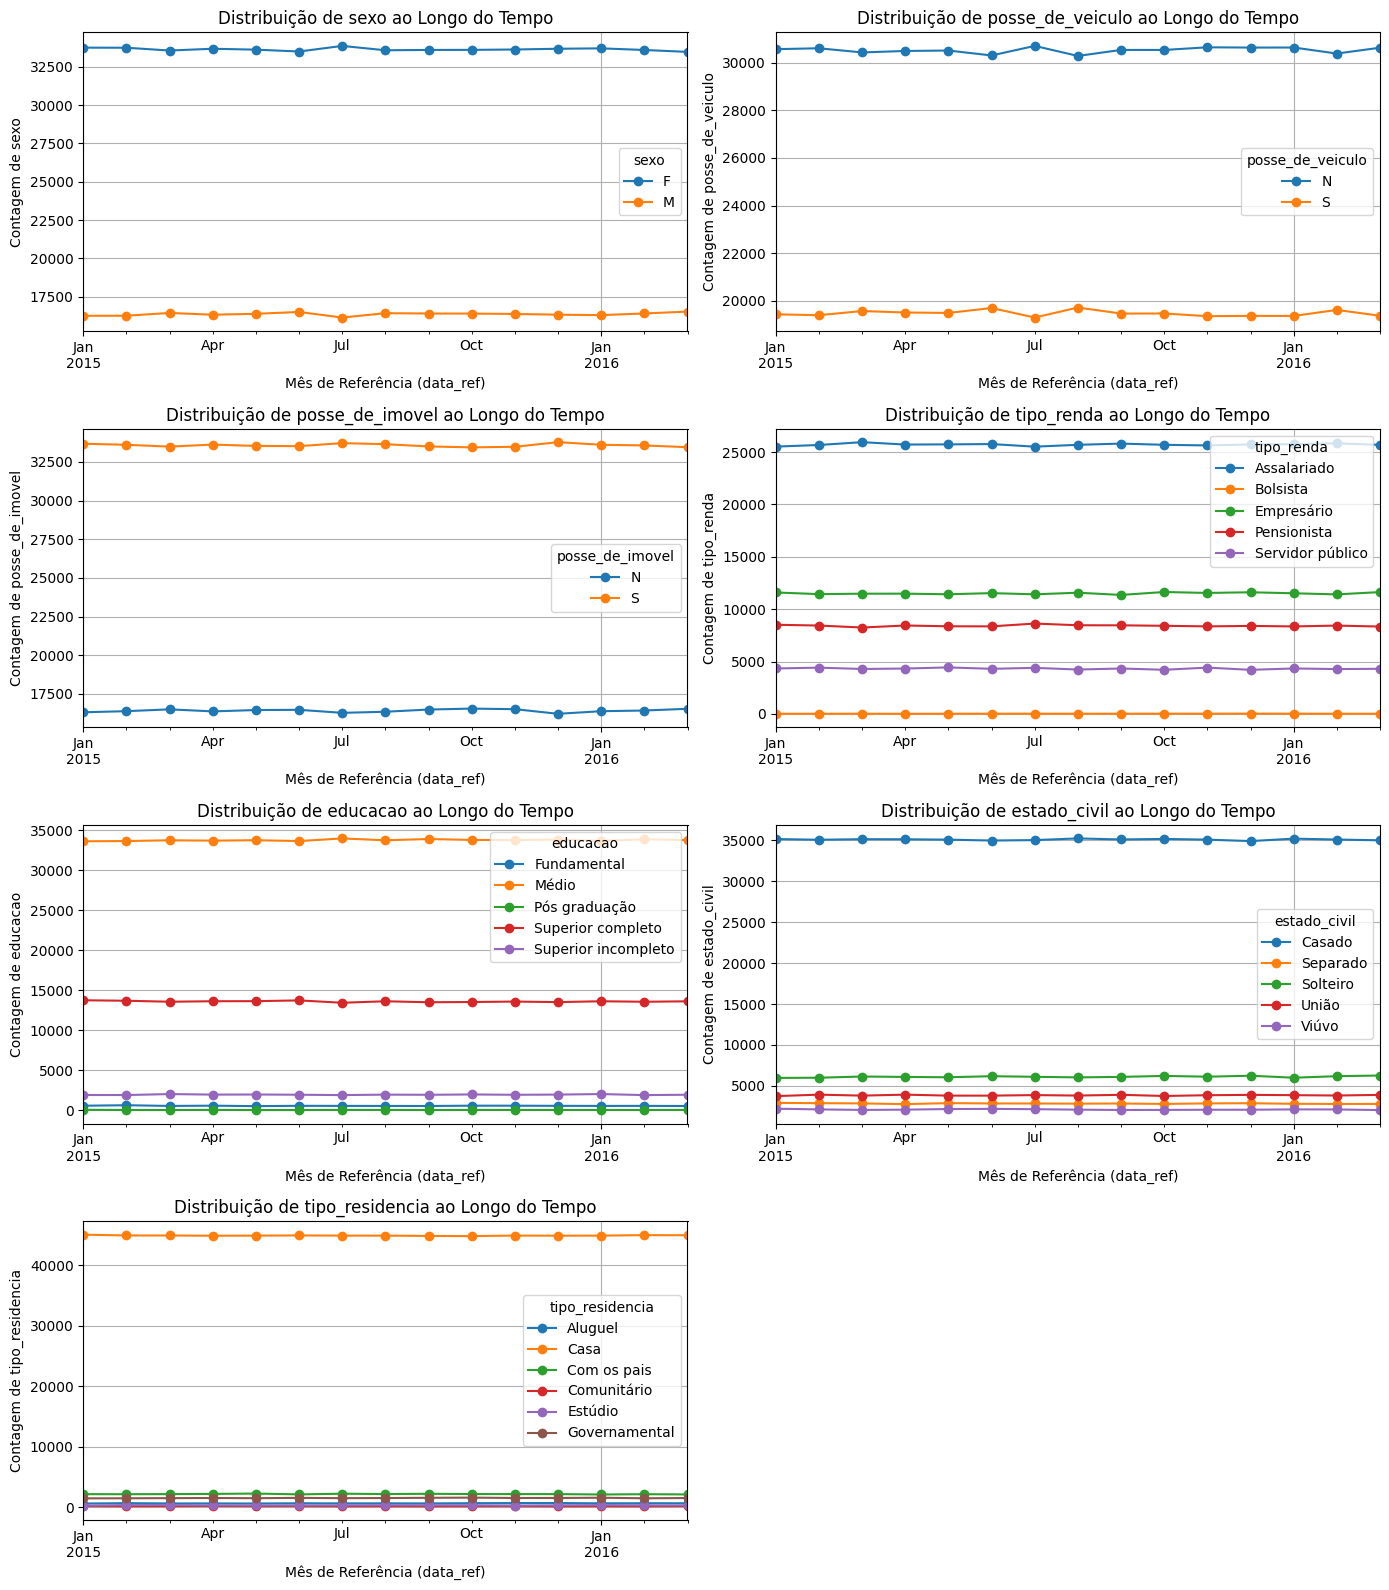

In [17]:
# Configuração dos subplots: ajusta automaticamente com base no número de variáveis qualitativas
num_vars = len(qualitativas)
cols = 2  # Número de colunas no layout
rows = (num_vars + 1) // cols  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))  # Ajusta o tamanho dos gráficos dinamicamente

# Flatten the axes array para iterar mais facilmente
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    df.groupby(['data_ref', var]).size().unstack().plot(
        marker='o', linestyle='-', ax=axes[i]
    )
    axes[i].set_title(f'Distribuição de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Contagem de {var}')
    axes[i].grid(True)

# Remover subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

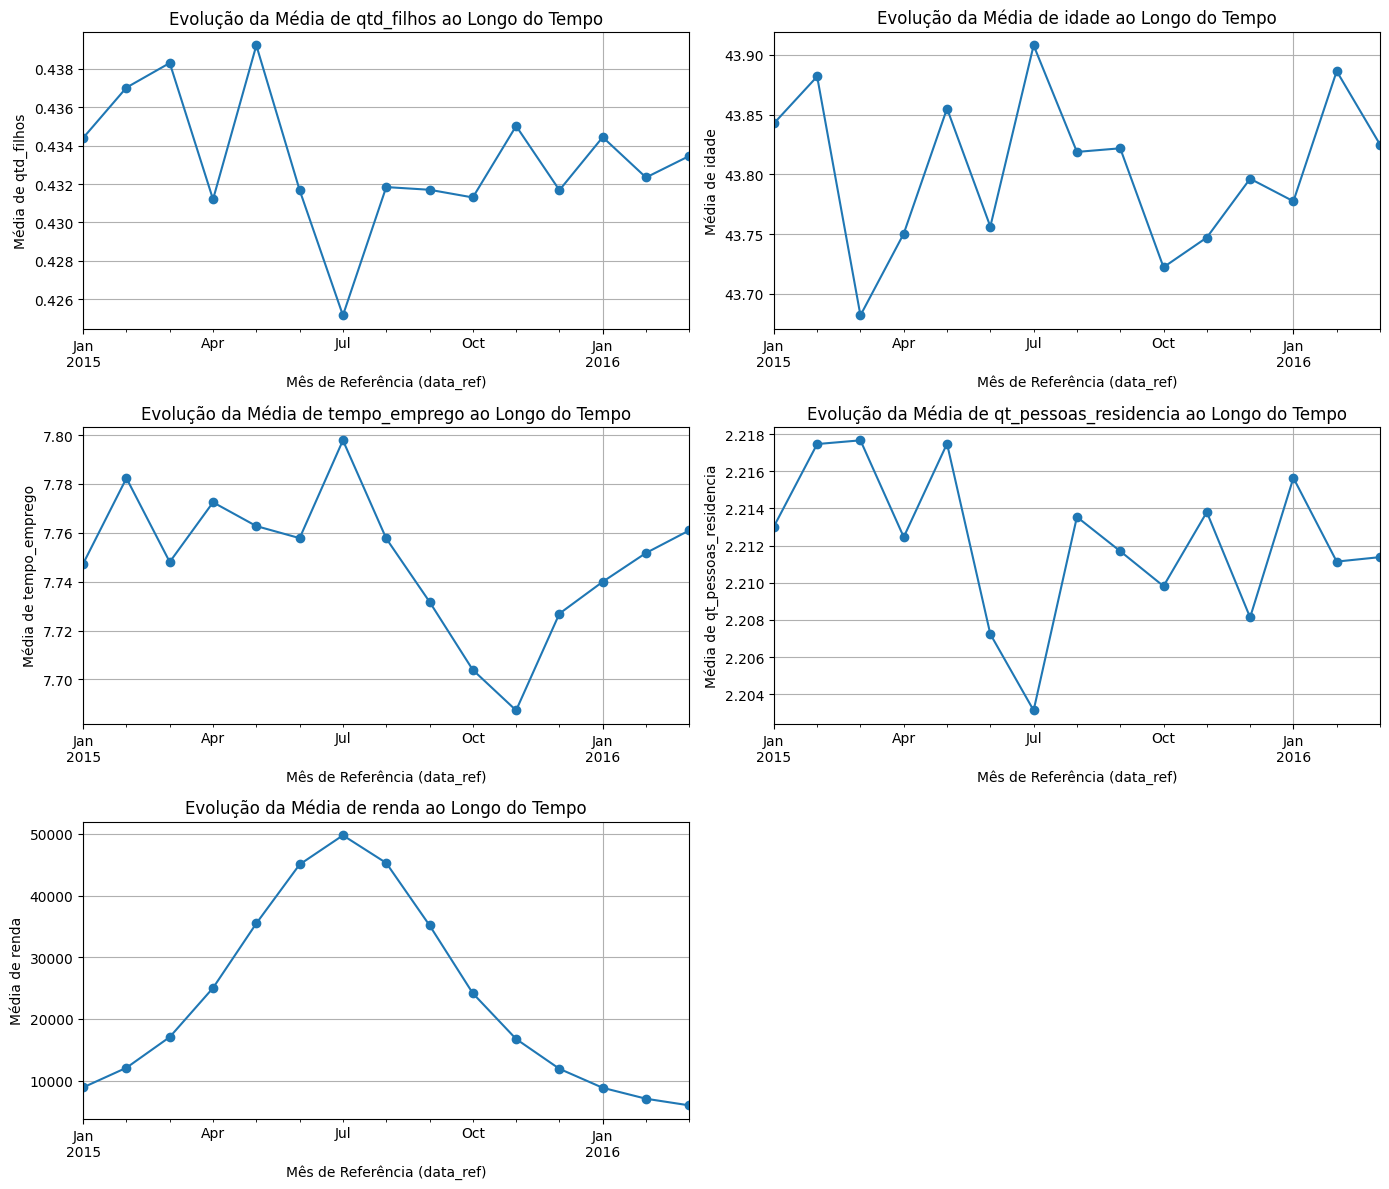

In [18]:
# Configuração dinâmica dos subplots com base no número de variáveis quantitativas
num_vars = len(quantitativas)
cols = 2  # Número de colunas no layout
rows = (num_vars + 1) // cols  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))  # Ajusta tamanho do gráfico dinamicamente

# Flatten the axes array para facilitar a iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    df.groupby('data_ref')[var].mean().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Evolução da Média de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Média de {var}')
    axes[i].grid(True)

# Remover subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


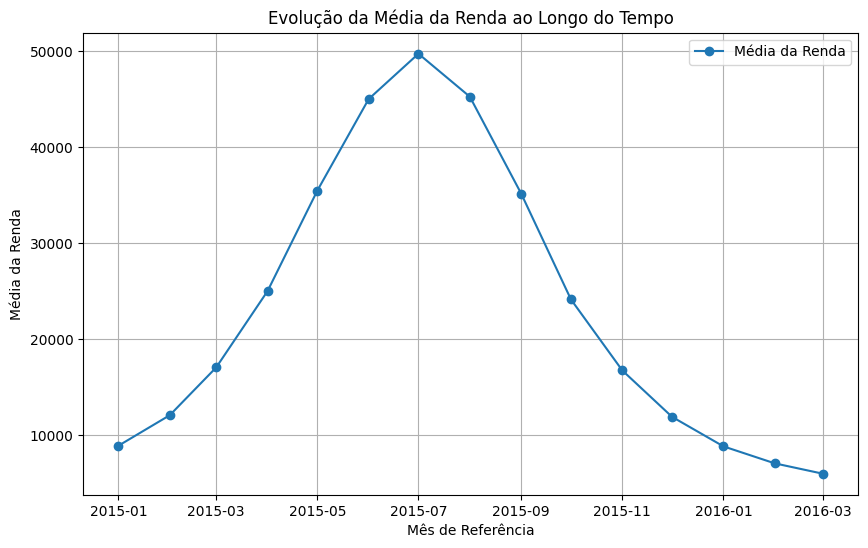

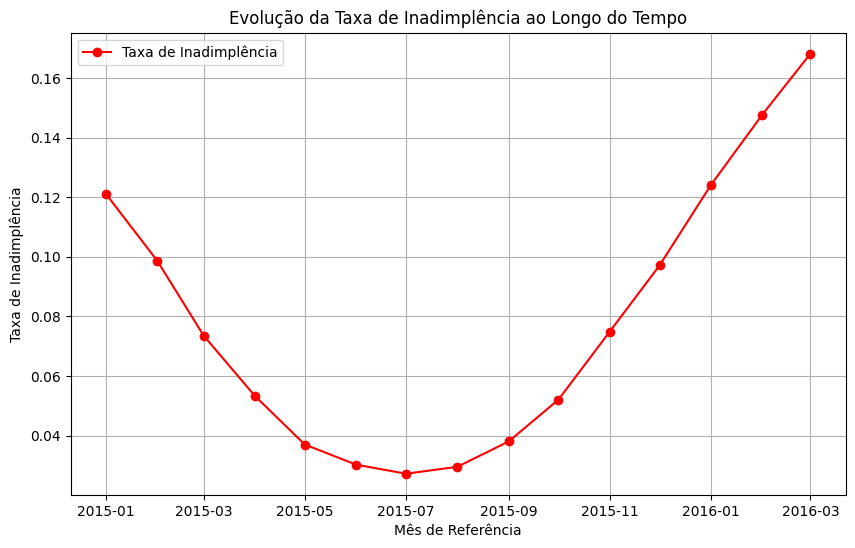

In [19]:
# Evolução da média da renda ao longo do tempo
renda_media_por_mes = df.groupby('data_ref')['renda'].mean()

plt.figure(figsize=(10, 6))
plt.plot(renda_media_por_mes.index, renda_media_por_mes.values, marker='o', label='Média da Renda')
plt.title('Evolução da Média da Renda ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Média da Renda')
plt.grid(True)
plt.legend()
plt.show()

# Evolução da taxa de inadimplência ao longo do tempo
# Assumindo que a variável de inadimplência seja binária (0 ou 1)
inadimplencia_por_mes = df.groupby('data_ref')['mau'].mean()

plt.figure(figsize=(10, 6))
plt.plot(inadimplencia_por_mes.index, inadimplencia_por_mes.values, marker='o', color='red', label='Taxa de Inadimplência')
plt.title('Evolução da Taxa de Inadimplência ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Taxa de Inadimplência')
plt.grid(True)
plt.legend()
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

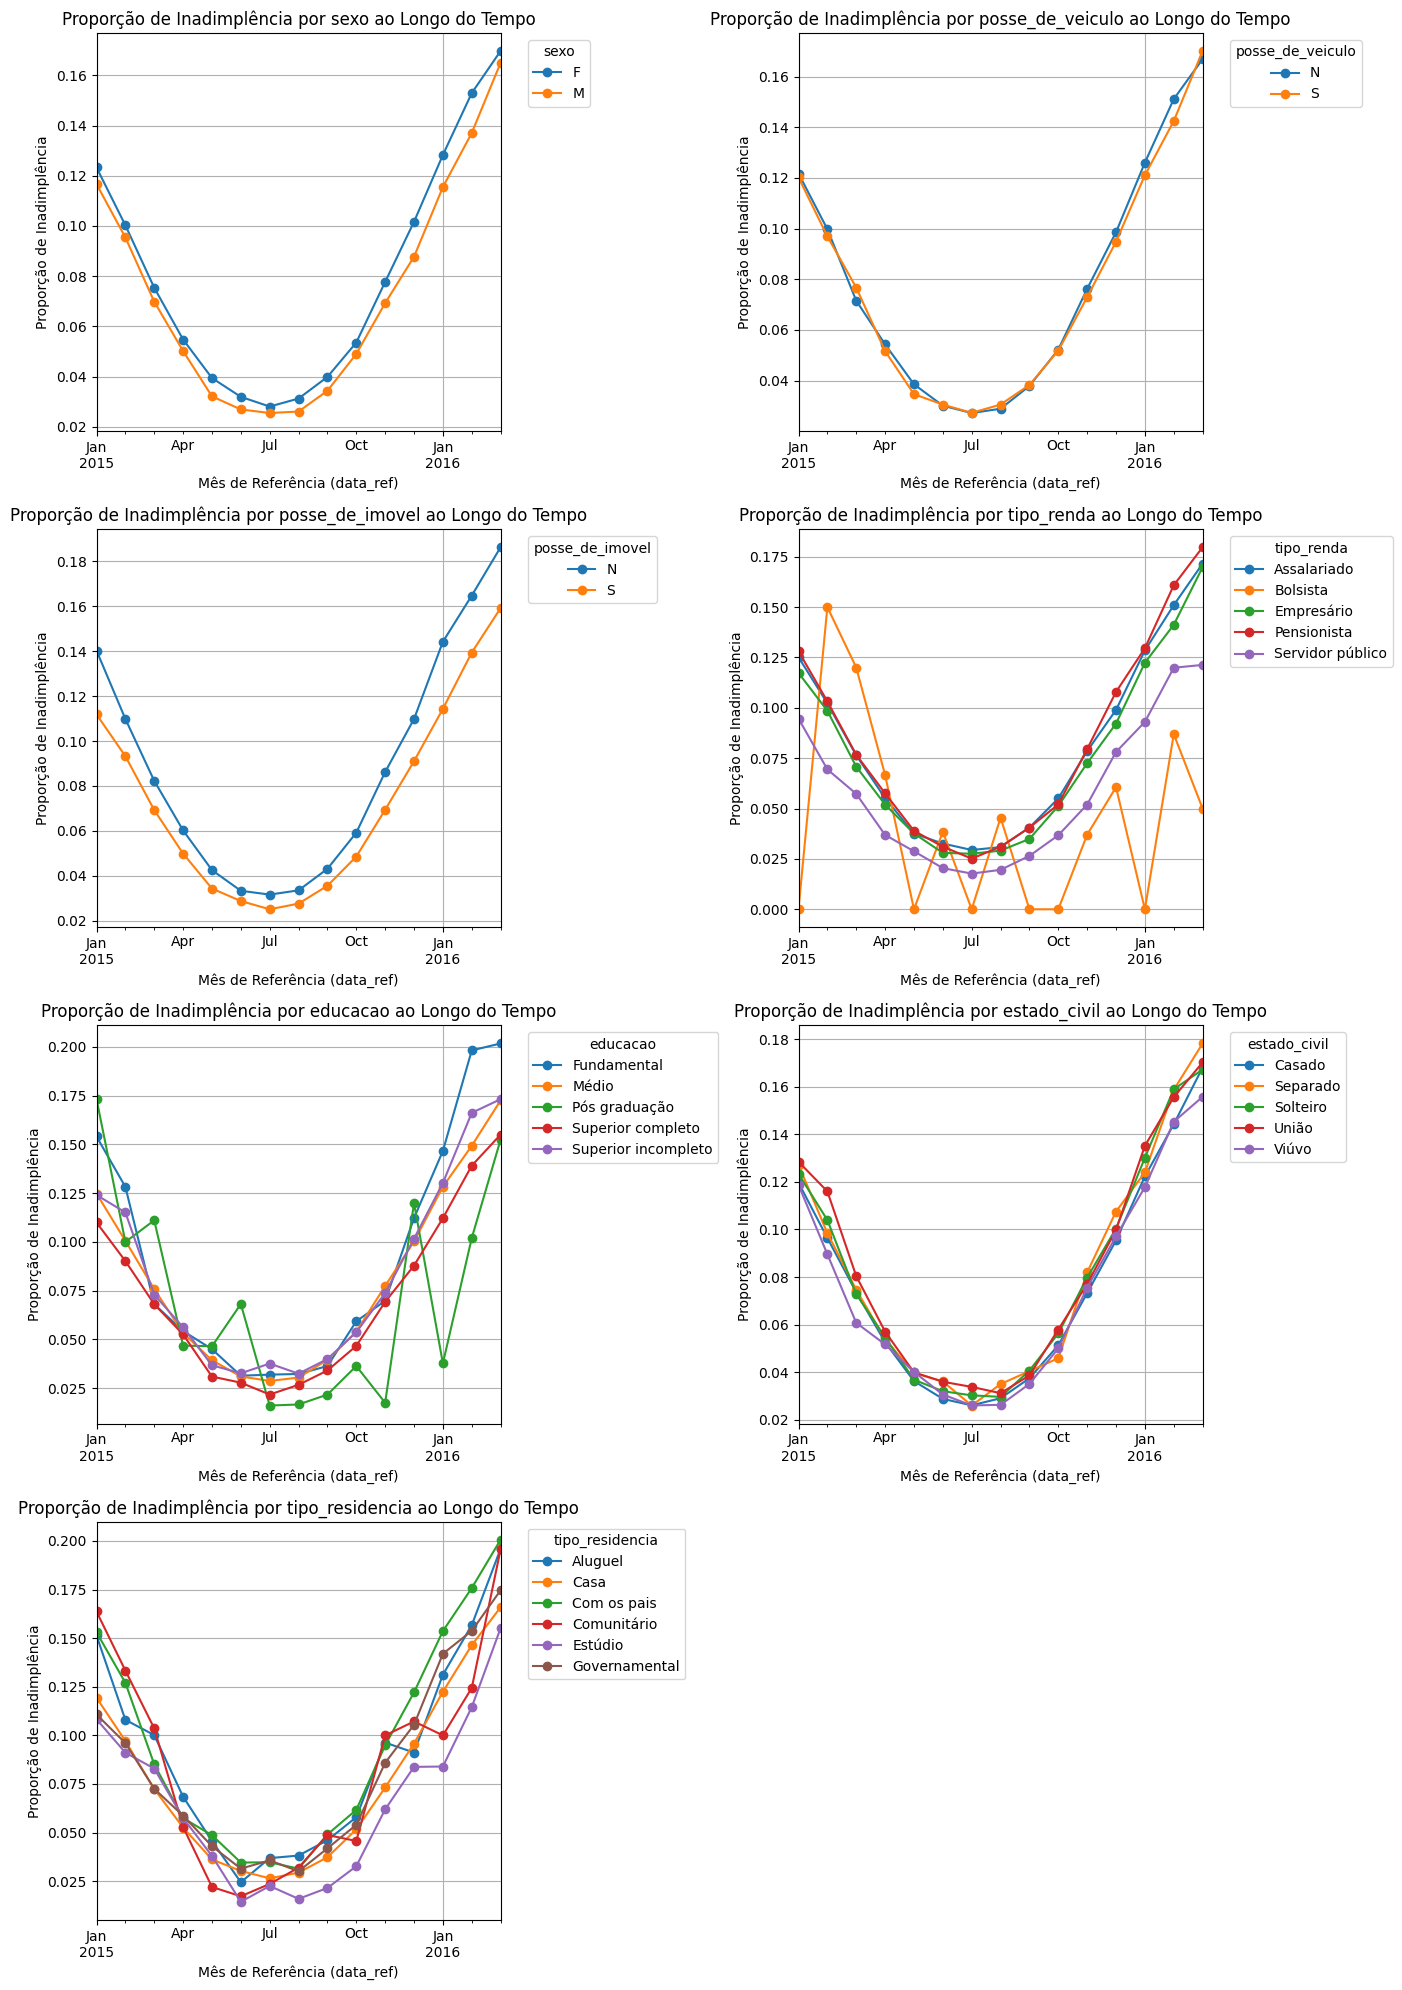

In [20]:
# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Tamanho ajustado para melhor visualização

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    # Calcular a proporção de inadimplência por data_ref e variável qualitativa
    data = df.groupby(['data_ref', var])['mau'].mean().unstack()
    
    # Plotar o gráfico
    data.plot(marker='o', linestyle='-', ax=axes[i])
    
    # Configurações do gráfico
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Remover o último subplot vazio se houver número ímpar de gráficos
if len(qualitativas) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

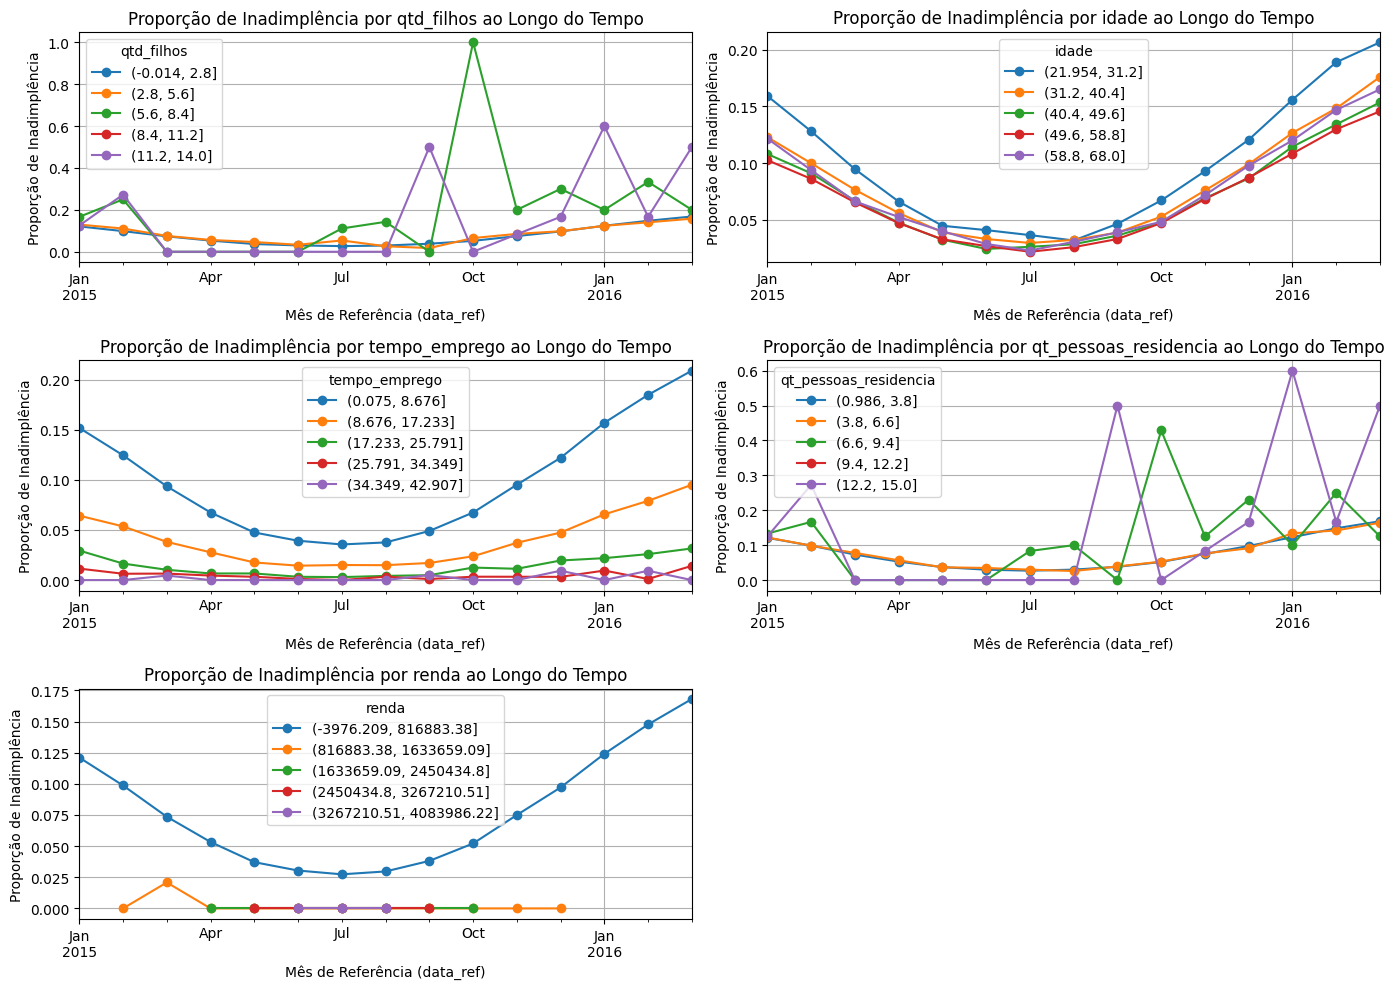

In [21]:
# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 5 gráficos, e 2 colunas

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    # Calcular a proporção de inadimplência por faixas da variável quantitativa ao longo do tempo
    data = df.groupby(['data_ref', pd.cut(df[var], bins=5)], observed=False)['mau'].mean().unstack()
    data.plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [22]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [23]:
# Excluir a variável 'posse_de_veiculo' (não discrimina)
df.drop(columns=['posse_de_veiculo'], inplace=True)

# Agrupar quantidade de filhos acima de 5 em uma única categoria "6+"
df['qtd_filhos'] = df['qtd_filhos'].apply(lambda x: '<6' if x <= 5 else '6+')

# Remover categorias 'Pensionista' e 'Bolsista' da variável 'tipo_renda'
df = df[~df['tipo_renda'].isin(['Pensionista', 'Bolsista'])]

# Agrupar "Pós-graduação" em "Superior ou mais" na variável 'educacao'
df['educacao'] = df['educacao'].replace({'Pós-graduação': 'Superior ou mais'})

# Criar nova variável 'faixa_idade', categorizando como "<30" e "30+"
df['faixa_idade'] = df['idade'].apply(lambda x: '<30' if x < 30 else '30+')

# Agrupar tempo de emprego acima de 25 anos em "25+ anos"
df['tempo_emprego'] = df['tempo_emprego'].apply(lambda x: "<25" if x < 25 else '25+ anos')

# Agrupar quantidade de pessoas na residência acima de 6 em "7+"
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].apply(lambda x: '<7' if x <= 6 else '7+')

# Limitar a renda a valores de até 800.000 para tratar outliers
df = df[df['renda'] <= 800000]


In [24]:
df.head()

,data_ref,index,sexo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,faixa_idade
0,2015-01-01,5733,F,N,<6,Empresário,Médio,Solteiro,Casa,43,<25,<7,2515.39,False,30+
1,2015-01-01,727,F,S,<6,Assalariado,Médio,Casado,Casa,35,<25,<7,3180.19,False,30+
2,2015-01-01,6374,F,N,<6,Assalariado,Médio,Casado,Casa,31,<25,<7,1582.29,False,30+
3,2015-01-01,9566,F,N,<6,Assalariado,Médio,Casado,Casa,54,<25,<7,13721.17,False,30+
4,2015-01-01,9502,F,N,<6,Assalariado,Superior incompleto,Solteiro,Casa,31,<25,<7,2891.08,False,30+


In [25]:
# Ordenando os dados por data de referência
df_sorted = df.sort_values(by='data_ref')

# Definindo o período de corte para os últimos 3 meses
cutoff_date = df_sorted['data_ref'].max() - pd.DateOffset(months=3)

# Dividindo os dados em treino e teste com base na data
train_df = df_sorted[df_sorted['data_ref'] <= cutoff_date]
test_df = df_sorted[df_sorted['data_ref'] > cutoff_date]

# Criando variáveis dummy para as variáveis categóricas, excluindo as colunas 'mau', 'data_ref' e 'index'
X_train = pd.get_dummies(train_df.drop(columns=['mau', 'data_ref', 'index']))
X_test = pd.get_dummies(test_df.drop(columns=['mau', 'data_ref', 'index']))

# Garantindo que X_train e X_test tenham as mesmas colunas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Definindo a variável resposta para treino e teste
y_train = train_df['mau']
y_test = test_df['mau']

In [26]:
# Ajustando o modelo de Regressão Logística com class_weight='balanced'
model = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=664)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=664)

In [27]:
# Ajustando o limiar para a classificação
threshold = 0.69  # Valor ajustado

# Avaliação na base de treino
y_prob_train = model.predict_proba(X_train)[:, 1]  # Probabilidades para a classe positiva na base de treino
y_pred_train_adjusted = (y_prob_train > threshold).astype(int)  # Aplicando o limiar ajustado

# Avaliação na base de teste
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva na base de teste
y_pred_test_adjusted = (y_prob_test > threshold).astype(int)  # Aplicando o limiar ajustado

# Matriz de Confusão e Relatório de Classificação para a base de treino
conf_matrix_train = confusion_matrix(y_train, y_pred_train_adjusted)
class_report_train = classification_report(y_train, y_pred_train_adjusted, target_names=['Classe 0', 'Classe 1'])

# Matriz de Confusão e Relatório de Classificação para a base de teste
conf_matrix_test = confusion_matrix(y_test, y_pred_test_adjusted)
class_report_test = classification_report(y_test, y_pred_test_adjusted, target_names=['Classe 0', 'Classe 1'])

# Exibindo resultados de forma mais legível
print("Avaliação na Base de Treino:")
print("Matriz de Confusão:")
print(conf_matrix_train)
print("\nRelatório de Classificação:")
print(class_report_train)

print("\nAvaliação na Base de Teste:")
print("Matriz de Confusão:")
print(conf_matrix_test)
print("\nRelatório de Classificação:")
print(class_report_test)

Avaliação na Base de Treino:
Matriz de Confusão:
[[458788   8383]
 [ 26985   3145]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.94      0.98      0.96    467171
    Classe 1       0.27      0.10      0.15     30130

    accuracy                           0.93    497301
   macro avg       0.61      0.54      0.56    497301
weighted avg       0.90      0.93      0.91    497301


Avaliação na Base de Teste:
Matriz de Confusão:
[[98715  8020]
 [14029  4028]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90    106735
    Classe 1       0.33      0.22      0.27     18057

    accuracy                           0.82    124792
   macro avg       0.60      0.57      0.58    124792
weighted avg       0.80      0.82      0.81    124792



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [28]:
def ks_statistic(y_true, y_prob):
    """Calcula a estatística KS"""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return max(tpr - fpr)

def gini_coefficient(y_true, y_prob):
    """Calcula o coeficiente Gini"""
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Métricas na base de treino
accuracy_train = accuracy_score(y_train, y_pred_train_adjusted)
ks_train = ks_statistic(y_train, y_prob_train)
gini_train = gini_coefficient(y_train, y_prob_train)

# Métricas na base de teste (OOT)
accuracy_test = accuracy_score(y_test, y_pred_test_adjusted)
ks_test = ks_statistic(y_test, y_prob_test)
gini_test = gini_coefficient(y_test, y_prob_test)

# Exibindo os resultados de forma mais legível e formatada
print("Avaliação na Base de Treino:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"KS: {ks_train:.4f}")
print(f"Gini: {gini_train:.4f}")

print("\nAvaliação na Base Out-of-Time (Teste):")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"KS: {ks_test:.4f}")
print(f"Gini: {gini_test:.4f}")


Avaliação na Base de Treino:
Acurácia: 0.9289
KS: 0.4056
Gini: 0.5419

Avaliação na Base Out-of-Time (Teste):
Acurácia: 0.8233
KS: 0.3234
Gini: 0.4420


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

In [29]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

> Os dados nulos são relacionados a váriavel "tempo_emprego" na categoria "pensionista". Irei eliminar os dados nulos pois faz mais sentido.


In [30]:
# 1. Substituição de nulos
def substituir_nulos(df):
    df.dropna(inplace=True)
    return df

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

> Os outliers são os dados que estão fora do intervalo entre 1,5 vezes o IQR abaixo do primeiro quartil (Q1) e 1,5 vezes o IQR acima do terceiro quartil (Q3).

In [41]:
def remover_outliers(df):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [42]:
# 3. Seleção de variáveis usando feature importance
def selecionar_variaveis(X, y, n_features=8):
    model = RandomForestClassifier()
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_features:]  # Seleciona os índices das n_features mais importantes
    selected_columns = X.columns[indices] # Nomes das variáveis selecionadas
    print("Variáveis selecionadas:", selected_columns)
    return X[selected_columns]

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [43]:
# 4. Aplicação de PCA
def aplicar_pca(X, n_components=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [34]:
# 5. Criação de dummies
def criar_dummies(df):
    return pd.get_dummies(df, drop_first=True)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [70]:
def preprocessamento(df):
    y = df['mau']
    X = df.drop(columns=['mau'])
    
    # Aplicar as funções de pré-processamento
    df = substituir_nulos(df)
    df = remover_outliers(df)
    X = criar_dummies(X)    
     
    # Seleção de variáveis
    X_selecionado = selecionar_variaveis(X, y, n_features=8)    
      
    # Aplicação de PCA
    X_pca = aplicar_pca(X_selecionado, n_components=5)
    
    # Adicionar a variável alvo de volta
    X_pca['mau'] = y.reset_index(drop=True)
    
    return X_pca

In [71]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [72]:
# Função de transformação que usa a função de pré-processamento
def preprocessamento_transformer(df):
    return preprocessamento(df)

# Criação da pipeline
preprocessamento_pipeline = Pipeline([
    ('preprocessamento', FunctionTransformer(preprocessamento_transformer, validate=False)),
])

In [73]:
df_processado = preprocessamento_pipeline.transform(df_treino)
print(df_processado.head())

Variáveis selecionadas: Index(['sexo_M', 'qtd_filhos', 'tipo_renda_Empresário', 'posse_de_veiculo_S',
       'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda'],
      dtype='object')
        PC1       PC2       PC3       PC4       PC5    mau
0 -1.406512 -1.126643 -1.133713  1.272389  0.059558  False
1  0.020947 -0.786442  0.271998 -0.527138 -0.339180  False
2  2.456414  0.965567 -1.788327 -0.662595 -0.207745  False
3 -1.644986  0.476788 -0.579556 -0.760518  0.915149  False
4 -0.560758 -0.989393  0.435520 -0.503728 -0.947348  False


## Treinar um modelo de regressão logistica com o resultado

In [74]:
def ajustar_regressao_logistica(X_train, y_train):
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    return model

In [75]:
X_train = df_processado.drop(columns=['mau'])
y_train = df_processado['mau']

In [76]:
model = ajustar_regressao_logistica(X_train, y_train)

## Salvar o pickle file do modelo treinado

In [59]:
nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

## Uma rápida análise na base OOT

In [77]:
df_oot.shape

(124918, 13)

In [79]:
df_oot_processado = preprocessamento(df_oot)
X_oot = df_oot_processado.drop(columns='mau')
y_oot = df_oot['mau']

y_probs = model.predict_proba(X_oot)[:, 1]
threshold = 0.67
y_pred_threshold = (y_probs >= threshold).astype(int)

cm = confusion_matrix(y_oot, y_pred_threshold)
print(cm)

Variáveis selecionadas: Index(['sexo_M', 'qtd_filhos', 'tipo_renda_Empresário', 'posse_de_veiculo_S',
       'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda'],
      dtype='object')
[[98183  8663]
 [14571  3501]]


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [2]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
dataset = df.sample(50000)

In [6]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [8]:
data = dataset.sample(frac=0.95, random_state=222)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [10]:
data.qtd_filhos = data.qtd_filhos.astype(float) #forçando a variável qnt de filhos como numérica

In [12]:
from pycaret.classification import *


In [14]:
clf = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.0%


In [15]:
lightgbm = create_model('lightgbm', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7176,0.7586,0.6641,0.1680,0.2681,0.1642,0.2242
1,0.7233,0.7621,0.6795,0.1737,0.2767,0.1743,0.2367
2,0.7218,0.7813,0.6988,0.1761,0.2813,0.1791,0.2451
3,0.7119,0.7529,0.6641,0.1649,0.2642,0.1593,0.2195
4,0.7233,0.7503,0.6486,0.1685,0.2675,0.1642,0.2213
5,0.7206,0.7758,0.6680,0.1703,0.2714,0.1681,0.2287
6,0.7236,0.7882,0.7066,0.1784,0.2848,0.1832,0.2504
7,0.7272,0.7816,0.6873,0.1773,0.2819,0.1804,0.2439
8,0.7191,0.7603,0.6641,0.1688,0.2692,0.1655,0.2255


In [16]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.7379,0.5483,0.1690,0.2584,0.1582,0.1977
1,0.7750,0.7322,0.5290,0.1796,0.2681,0.1718,0.2070
2,0.7561,0.7554,0.5598,0.1722,0.2634,0.1638,0.2049
3,0.7546,0.7193,0.4981,0.1583,0.2402,0.1384,0.1709
4,0.7567,0.7208,0.4942,0.1588,0.2404,0.1388,0.1708
5,0.7618,0.7409,0.5058,0.1648,0.2486,0.1485,0.1817
6,0.7639,0.7542,0.5753,0.1808,0.2752,0.1777,0.2204
7,0.7639,0.7454,0.5251,0.1704,0.2573,0.1583,0.1940
8,0.7579,0.7167,0.4749,0.1553,0.2341,0.1322,0.1615


Fitting 10 folds for each of 10 candidates, totalling 100 fits


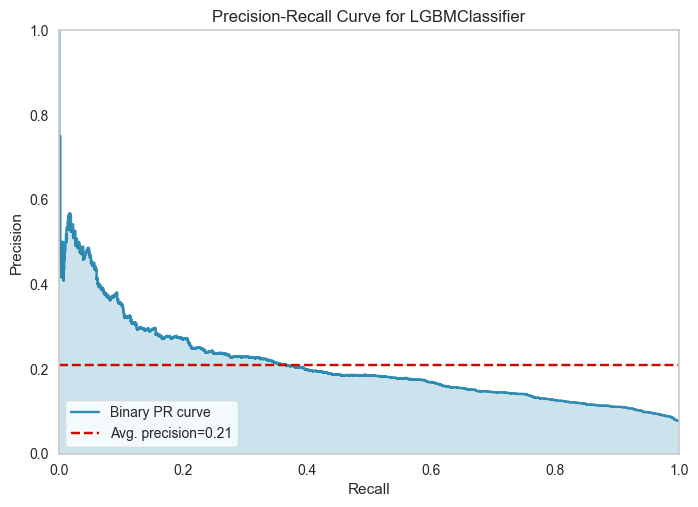

In [17]:
plot_model(tuned_lightgbm, plot = 'pr')

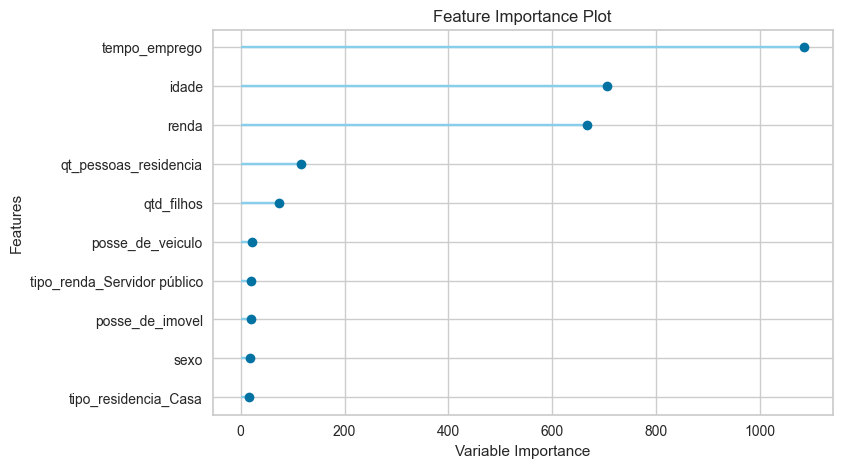

In [18]:
plot_model(tuned_lightgbm, plot='feature')

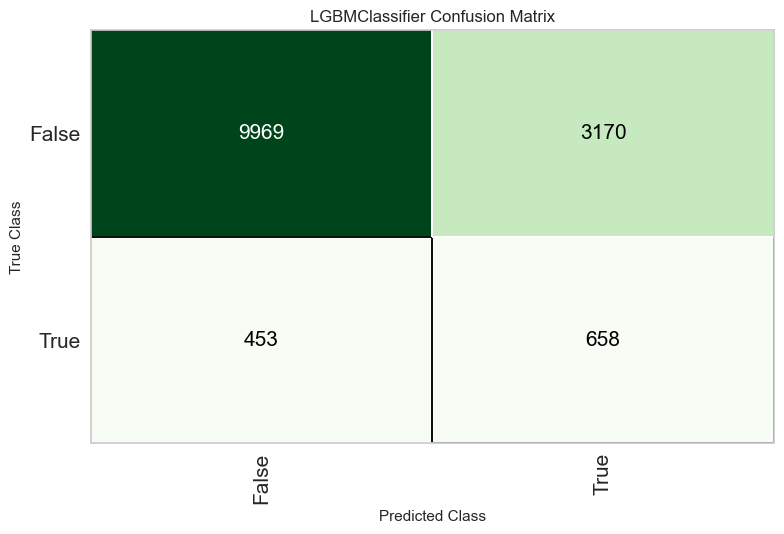

In [19]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [38]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [40]:

predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7458,0.7420,0.5923,0.1719,0.2665,0.1656,0.2123


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
31911,F,N,N,0.0,Empresário,Médio,Casado,Casa,50,4.931507,2.0,2826.719971,False,1,0.7297
915,F,N,N,0.0,Pensionista,Médio,Casado,Casa,63,NaN,2.0,1828.160034,False,1,0.7239
25214,F,S,S,2.0,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,18865.480469,False,0,0.9944
22495,M,S,N,0.0,Assalariado,Médio,Casado,Casa,52,11.202740,2.0,4952.339844,False,0,0.8494
28828,M,N,S,1.0,Assalariado,Médio,Casado,Casa,44,4.594521,3.0,7279.740234,False,0,0.5412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42388,F,S,S,0.0,Assalariado,Médio,União,Casa,40,8.605479,2.0,7539.520020,False,0,0.7332
19376,M,S,S,0.0,Assalariado,Médio,Casado,Casa,47,1.515069,2.0,11467.120117,False,0,0.8984
21595,F,N,N,0.0,Assalariado,Médio,Casado,Casa,40,13.873973,2.0,11528.530273,False,0,0.8818
42950,F,N,S,0.0,Assalariado,Superior incompleto,União,Casa,25,4.797260,2.0,4180.379883,False,1,0.6916


In [42]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [44]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight='balanced',
                     

In [46]:
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7688,0.8934,0.8938,0.2382,0.3761,0.2885,0.3843


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [48]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7364,0.7435,0.6009,0.1823,0.2798,0.1715,0.2174


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,N,1,Assalariado,Superior completo,Casado,Governamental,33,2.172603,3.0,8663.099609,False,0,0.7014
1,M,N,S,1,Assalariado,Médio,Casado,Casa,37,8.306849,3.0,716.309998,False,1,0.8761
2,M,S,S,0,Assalariado,Superior completo,Separado,Com os pais,54,20.931507,1.0,11716.629883,False,0,0.9844
3,F,S,S,2,Assalariado,Superior incompleto,Casado,Casa,31,0.353425,4.0,2687.899902,False,1,0.7437
4,F,N,N,1,Assalariado,Médio,União,Casa,41,9.589041,3.0,7413.240234,False,0,0.9089


## Salvar o arquivo do modelo treinado

In [50]:
save_model(final_lightgbm,'Final LightGBM Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight='balanced',
      

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.